# Importing Libraries and Pre-Processing

In [1]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize


import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
### Importing and Preparing Data
# load dataset
full_train_data = pd.read_csv('train_x.csv').to_numpy()
full_train_label = pd.read_csv('train_y.csv').to_numpy().flatten()
test_data = pd.read_csv('test_x.csv').to_numpy()
test_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [3]:
# Training and Validation Set Split
train_data, val_data, train_label, val_label = train_test_split(
    full_train_data, full_train_label, test_size = 0.3, 
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3072), y = (35000,)
Validation data:  X = (15000, 3072), y = (15000,)


In [5]:
# Dimensionality Reduction - PCA
pca_scaled = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
X_train_pca = pca_scaled.fit_transform(train_data)
X_val_pca = pca_scaled.transform(val_data)
print("PCA train data shape:      {}".format(X_train_pca.shape))
print("PCA validation data shape: {}".format(X_val_pca.shape))

PCA train data shape:      (35000, 34)
PCA validation data shape: (15000, 34)


In [5]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
        fd_array[i] = fd
    return fd_array

In [6]:
X_train_hog = extract_hog(train_data)
X_val_hog = extract_hog(val_data)

In [7]:
X_full_train_hog = extract_hog(full_train_data)

In [8]:
# Dimensionality Reduction - HOG-PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components=150, whiten=False, random_state=0))
X_train_hg = pca_scaled2.fit_transform(X_train_hog)
X_val_hg = pca_scaled2.transform(X_val_hog)
print("PCA train data shape:      {}".format(X_train_hg.shape))
print("PCA validation data shape: {}".format(X_val_hg.shape))

PCA train data shape:      (42500, 150)
PCA validation data shape: (7500, 150)


# Classification

### Random Forest

In [6]:
# Random Search with several parameters using training data
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'bootstrap': bootstrap}

In [7]:
# Use the RandomSearchCV to search for best hyperparameters and fit model
rfr = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rfr, param_distributions = random_grid, 
    n_iter = 10, cv = 4, verbose = 2, random_state = 32, n_jobs = -1)
tic = timeit.default_timer()
rf_random.fit(X_train_pca, train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.4min finished


time elapsed: 0:22:02.884271


In [8]:
rf_results = pd.DataFrame(rf_random.cv_results_)
print(rf_random.best_params_)
print(rf_random.best_score_)                 # 0.9999764705882352 0.4722857142857143
print(rf_random.score(X_val_pca, val_label)) # 0.4902666666666667 0.4835333333333333
# best parameters: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
# {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}

{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'gini', 'bootstrap': True}
0.47077142857142856
0.48306666666666664


In [12]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(StandardScaler(), 
                           PCA(n_components=34, whiten=True, random_state=0))
rfmod = RandomForestClassifier(
    n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_depth=90,
    max_features='sqrt', criterion='gini', bootstrap=True, n_jobs=-1)
rfm_pipe = make_pipeline(pca_pipe, rfmod)
tic = timeit.default_timer()
rfm_pipe.fit(full_train_data, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 170.00 seconds  0:01:34.405703

time elapsed: 0:01:34.405703


In [13]:
print(f"Train accuracy: {rfm_pipe.score(full_train_data, full_train_label)}") # 0.0.99994 0.99982
print(f"Test accuracy:  {rfm_pipe.score(test_data, test_label)}")             # 0.5016    0.4916

Train accuracy: 0.99982
Test accuracy:  0.4916


In [14]:
# Model prediction
pred = rfm_pipe.predict(test_data)

Accuracy: 0.492
Confusion matrix:
[[574  39  33  19  25  19  33  29 169  60]
 [ 26 596  15  30  13  23  29  34  73 161]
 [104  44 312  71 125  62 142  58  51  31]
 [ 47  49  65 304  32 189 129  75  32  78]
 [ 55  20 119  64 389  42 160  89  30  32]
 [ 20  23  67 188  46 400  92  90  41  33]
 [ 10  21  69  49 102  50 619  27  19  34]
 [ 38  33  29  54  78  72  56 510  36  94]
 [ 85  71   8  19  13  30   9  19 648  98]
 [ 35 181   9  31   8  22  27  31  92 564]]


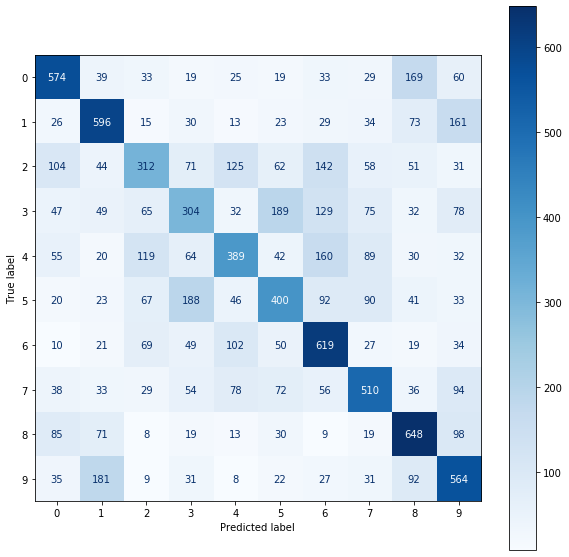

In [15]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_rf.png")

In [16]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1000
           1       0.55      0.60      0.57      1000
           2       0.43      0.31      0.36      1000
           3       0.37      0.30      0.33      1000
           4       0.47      0.39      0.42      1000
           5       0.44      0.40      0.42      1000
           6       0.48      0.62      0.54      1000
           7       0.53      0.51      0.52      1000
           8       0.54      0.65      0.59      1000
           9       0.48      0.56      0.52      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



In [17]:
# Save model file with pickle
rf_pickle = "Pickle_RF.pkl"  

with open(rf_pickle, 'wb') as file:  
    pickle.dump(rfm_pipe, file)

In [5]:
# Load model from file with pickle
rf_pickle = "Pickle_RF.pkl"  
with open(rf_pickle, 'rb') as file:  
    pickled_rf = pickle.load(file)

pickled_rf

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                    